# Thyroid Dataset

This is an application of an autoencoder model to a thyroid disease dataset available at: https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/

The first step is to import all the necessary modules. We will be displaying the data in a graphical form, so modules
such as matplotlib and seaborn are required.

In [191]:
#Dataset is available at: https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/
#Take ann_test.txt and ann_train.txt and combine them to get more data.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import seaborn as sns

%matplotlib inline

from pylab import rcParams

#Resizes the pyplot figures to be bigger
rcParams['figure.figsize'] = 15, 10

There isn't much data available, so we can combine both test and train data to form one data frame and perform a 
train-test-split to generate our training and testing data later on.

In [192]:
filePath = 'data/thyroid/ann-test.data'
filePath2 = 'data/thyroid/ann-train.data'

df = pd.read_table(filepath_or_buffer=filePath, header=None, sep=' ')
df2 = pd.read_table(filepath_or_buffer=filePath2, header=None, sep=' ')

#Adds df2 to df1
df = df.append(df2)

df.head()


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


In [193]:
#Columns 22 and 23 are extra columns that must be removed.

df = df.drop([22, 23], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0061,0.028,0.111,0.131,0.085,2
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0013,0.019,0.084,0.078,0.107,3
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0000,0.031,0.239,0.100,0.239,3
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0010,0.018,0.087,0.088,0.099,3
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0.0004,0.022,0.134,0.135,0.099,3


In [194]:
#Get value counts of each of the unique labels in column 21 of df. 3 is normal, 2 is hyperfunction , and 1 is subnormal.
pd.value_counts(df[21])

3    6666
2     368
1     166
Name: 21, dtype: int64

In [195]:
#Here we relabel so that 0 corresponds with normal, 1 with hyperfunction, and 2 with subnormal.
#The logic is that -3 would make normal have the label 0, hyperfunction -1 which becomes 1, and subnormal -2 
#which becomes 2
df[21] = abs(df[21] - 3)

In [196]:
pd.value_counts(df[21])

0    6666
1     368
2     166
Name: 21, dtype: int64

Here we generate a bar graph representing the frequencies of sick thyroids compared to healthy thyroids. Healthy thyroid data comprises the majority of our dataframe, so classification training won't be the most accurate due to the limited data from sick thyroids. 

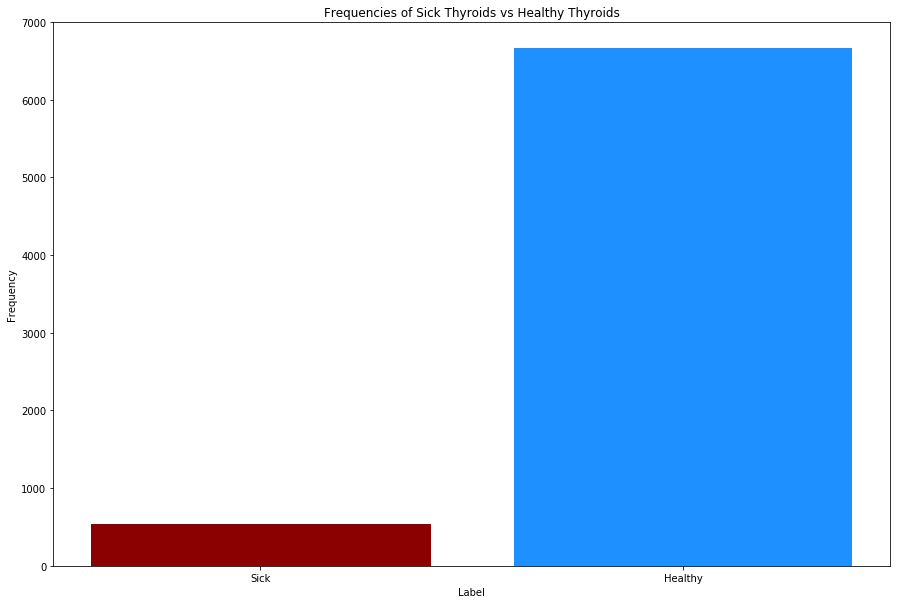

In [197]:
#Generate a bar graph to show the frequency of sick thyroids vs healthy thyroids
is_healthy = df.copy()

#Sets every value that's not 0 to 1 in column 21
is_healthy.loc[is_healthy[21] != 0, 21] = 1

x = pd.unique(is_healthy[21])
y = [pd.value_counts(is_healthy[21])[0], pd.value_counts(is_healthy[21])[1]]

pd.value_counts(is_healthy[21])
barchart = plt.bar(x, y, color='dodgerblue')
barchart[1].set_color('darkred')

plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title("Frequencies of Sick Thyroids vs Healthy Thyroids")


#1 stands for the healthy thyroids and 0 is the sick
plt.xticks(range(2), ['Sick', 'Healthy'])
plt.show()



X_train consists only of the healthy thyroid data because it comprises the majority of the data. The model will be trained on this data so that ideally, sick thyroid data would be labeled as an anomaly. 

In [212]:
#Train test split of 0.2, meaning 20% of the data is reserved for testing.
#X_train is only composed of normal thyroid data
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
X_train = X_train[X_train[21] == 0]
X_train = X_train.drop([21], axis=1)

y_test = X_test[21]
X_test = X_test.drop([21], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(5341, 21)

Here, we see the architecture of the autoencoder model. The model has an input and output layer with three hidden layers in between. The layers get smaller in the first half of the data flow to represent encoding, and return to the input dimension in the second half to represent decoding, or a reconstruction of the original data. 

In [213]:


input_dim = X_train.shape[1]
encoder_dim = 16

input_layer = Input(shape=(input_dim, ))

hidden_1 = Dense(encoder_dim, activation='tanh', activity_regularizer=regularizers.l2(0.01))(input_layer)

hidden_2 = Dense(int(encoder_dim/2), activation='relu')(hidden_1)

hidden_3 = Dense(encoder_dim, activation='tanh')(hidden_2)

decoder = Dense(input_dim, activation='relu')(hidden_3)

autoencoder = Model(inputs = input_layer, outputs = decoder)


In [214]:
n_epochs = 50
batch_size = 21

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    #loss='mean_squared_logarithmic_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_thyroid.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 5341 samples, validate on 1440 samples
Epoch 1/50
5341/5341 [==============================] - 1s - loss: 0.1123 - acc: 0.4411 - val_loss: 0.0574 - val_acc: 0.5028
Epoch 2/50
5341/5341 [==============================] - 1s - loss: 0.0413 - acc: 0.5477 - val_loss: 0.0323 - val_acc: 0.5688
Epoch 3/50
5341/5341 [==============================] - 1s - loss: 0.0272 - acc: 0.6048 - val_loss: 0.0253 - val_acc: 0.6028
Epoch 4/50
5341/5341 [==============================] - 1s - loss: 0.0180 - acc: 0.7066 - val_loss: 0.0111 - val_acc: 0.8535
Epoch 5/50
5341/5341 [==============================] - 1s - loss: 0.0091 - acc: 0.8888 - val_loss: 0.0090 - val_acc: 0.8861
Epoch 6/50
5341/5341 [==============================] - 1s - loss: 0.0074 - acc: 0.8981 - val_loss: 0.0075 - val_acc: 0.8583
Epoch 7/50
5341/5341 [==============================] - 1s - loss: 0.0065 - acc: 0.8987 - val_loss: 0.0074 - val_acc: 0.9104
Epoch 8/50
5341/5341 [==============================] - 1s - loss: 0.0061 - a

# Predictions

Now we move on to prediction and some basic data analysis. First we load our saved model and generate predictions.
Then we calculate the mean squared error for each point and create a data frame with the MSE and the true class.

In [216]:
autoencoder = load_model('model_thyroid.h5')

predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

,reconstruction_error,true_class
count,1440.000000,1440.000000
mean,0.004750,0.103472
std,0.015149,0.374280
min,0.000002,0.000000
25%,0.000010,0.000000
50%,0.000041,0.000000
75%,0.000235,0.000000
max,0.137529,2.000000


The threshold is calculated from basic statistical summary seen above. Anything above the threshold is considered an outlier with this assumption, and is graphed correspondingly. 

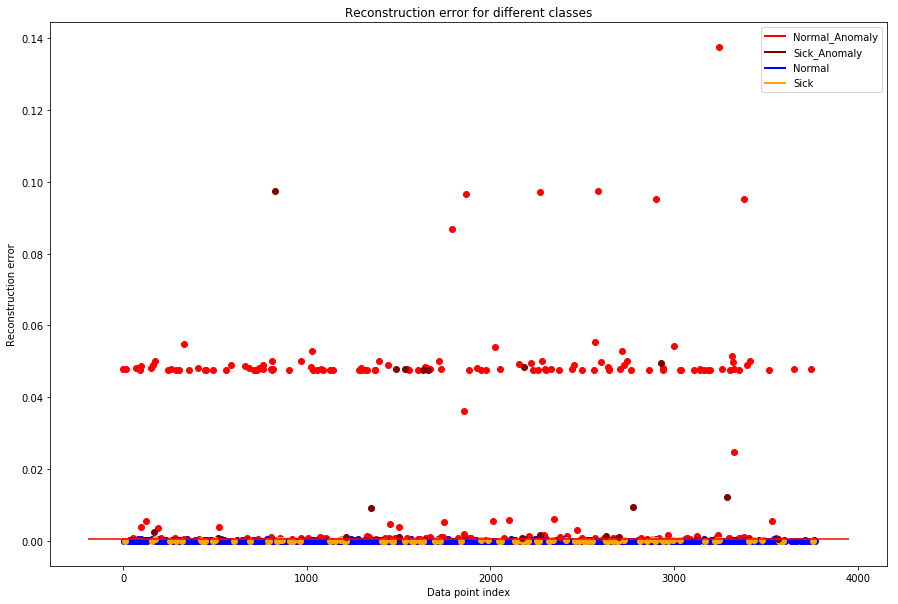

In [217]:
#threshold is set to be 1.5 * IQR + Q3 for determining outliers.
threshold = 1.5 * (error_df.quantile(0.75)[0] - error_df.quantile(0.25)[0]) + error_df.quantile(0.75)[0]

from matplotlib.lines import Line2D

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
entries = []

for name, group in groups:
    for i in range(0, len(group)):
        entries.append((name , group.index[i], group.reconstruction_error.iloc[i]))

#To label outlier we must consider the reconstruction error for each group entry. 
for f in entries:
    if f[2] > threshold:
        if f[0] == 0:
            ax.plot(f[1], f[2], color = 'r', marker='o', ms=6, linestyle='',
                label= "normal_outlier")
        else:
            ax.plot(f[1], f[2], color='maroon', marker='o', ms=6, linestyle='',
                label= "sick_outlier")
    else:
        if f[0] == 0:
            ax.plot(f[1], f[2], color='blue', marker='o', ms=6, linestyle='',
                label= "normal")
        else:
            ax.plot(f[1], f[2], color='orange', marker='o', ms=6, linestyle='',
                label= "sick")

            
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.legend()
legend_points = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='maroon', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='orange', lw=2)]

ax.legend(legend_points, ['Normal_Anomaly', 'Sick_Anomaly', 'Normal', 'Sick'])
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

It appears that the majority of the anomalies are normal thyroid data.

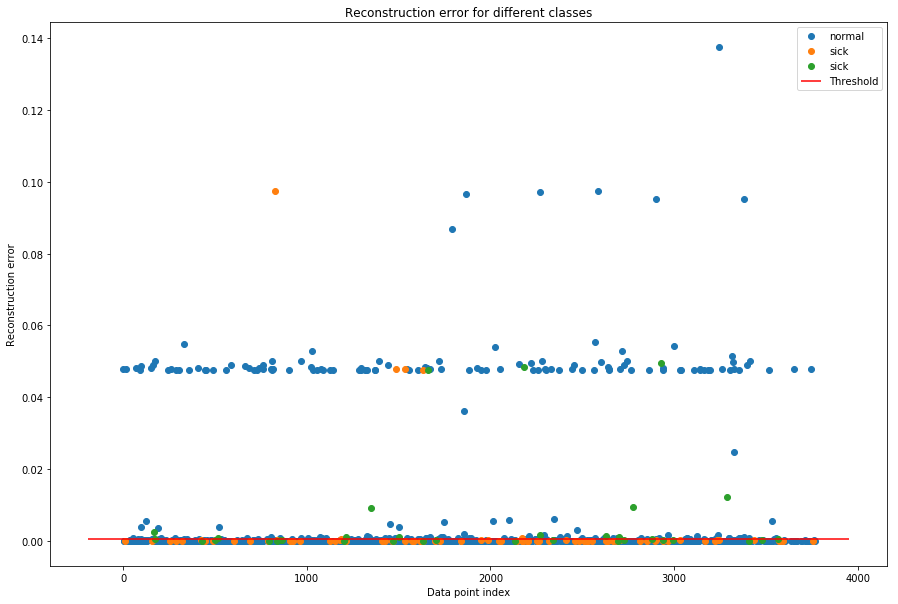

In [218]:



groups = error_df.groupby('true_class')


fig, ax = plt.subplots()
entries = []

        
for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=6, linestyle='',
            label= "normal" if name == 0 else "sick")
            
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

       reconstruction_error  true_class
count            534.000000  534.000000
mean               0.003777    1.310861
std                0.013817    0.463280
min                0.000004    1.000000
25%                0.000019    1.000000
50%                0.000074    1.000000
75%                0.000322    2.000000
max                0.097540    2.000000


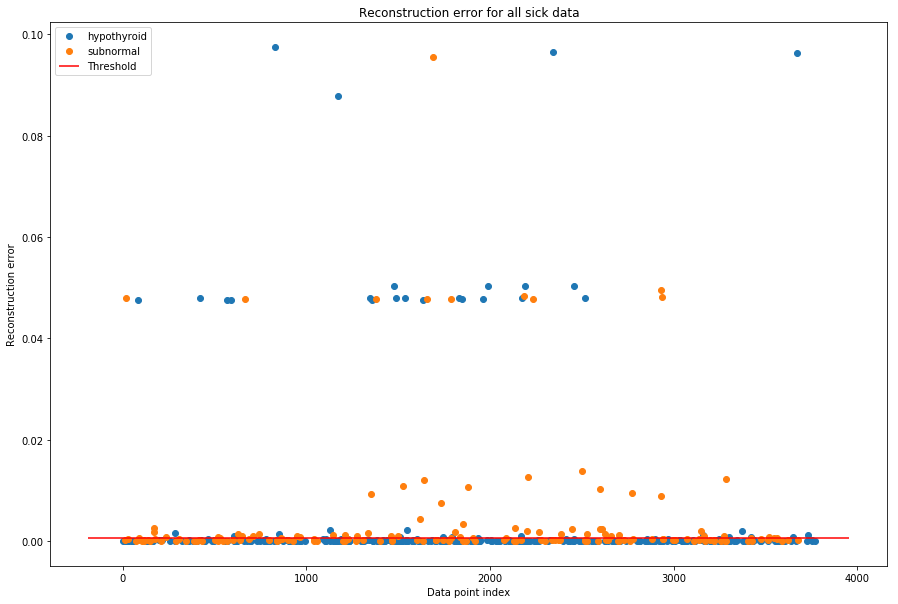

In [237]:
sick_test= df.copy()
sick_test = sick_test[sick_test[21] != 0]
y_sick_test = sick_test[21]
sick_test = sick_test.drop([21], axis=1)
sick_test = sick_test.values

a_predictions = autoencoder.predict(sick_test)

a_mse = np.mean(np.power(sick_test - a_predictions, 2), axis=1)
a_error_df = pd.DataFrame({'reconstruction_error': a_mse,
                        'true_class': y_sick_test})

print(a_error_df.describe())

a_groups = a_error_df.groupby('true_class')


fig, ax = plt.subplots()
entries = []

        
for name, group in a_groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=6, linestyle='',
            label= "hypothyroid" if name == 1 else "subnormal")
            
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for all sick data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Plotting all of the sick points from the original dataset, it is still the case that the majority of them fall under the original threshold line.

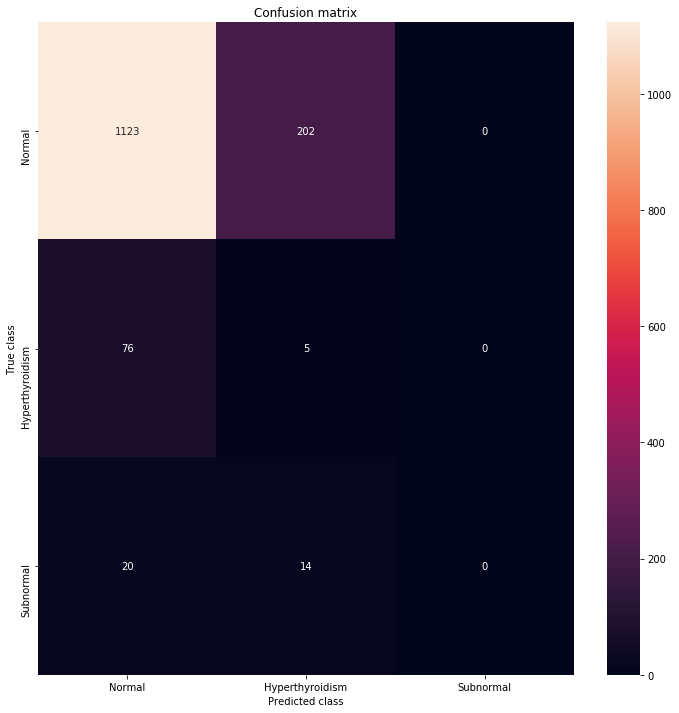

In [219]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)



Labels = ['Normal', 'Hyperthyroidism', 'Subnormal']



y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [238]:
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=1) - TP
FN = np.sum(conf_matrix, axis=0) - TP

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("Precision: ")
for i in range(0, len(Labels)):
    try:
        print("%s: %f" % (Labels[i], precision[i]))
    except:
        print("%s: nan" % (Labels[i]))
    
print("\nRecall: ")
for i in range(0, len(LABELS)):
    try:
        print("%s: %f" % (Labels[i], recall[i]))
    except:
        print("%s: nan" % (Labels[i]))


Precision: 
Normal: 0.847547
Hyperthyroidism: 0.061728
Subnormal: 0.000000

Recall: 
Normal: 0.921247
Hyperthyroidism: 0.022624
Subnormal: nan


C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


It seems that training the model on the normal thyroid data does not mean that it is able to accurately predict the likelihood of a sick thyroid. Even for normal thyroid data, the precision is pretty low at roughyl 84.8% of prediction being correct in the test sample. 

Additionally, most of the anomalies were normal thyroids. There likely weren't enough data points for the model to train on, resulting in a possible lack of diversity in the data and a lower model accuracy overall.



In [211]:
#Clears keras session. 
from keras import backend as K

K.clear_session()